# Results

This notebook contains graphs and results for the results

A lot of stuff is copy pasted around, which is mostly just to ensure that modifying a previous plot wont affect later ones

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
class ResultValue:
    def __init__(self, average: float, low_five: float, high_five: float) -> None:
        self.average = average
        self.low_five = low_five
        self.high_five = high_five

    def __repr__(self) -> str:
        return f"ResultValue(average={self.average}, low_five={self.low_five}, high_five={self.high_five})"


class TimingResult:
    def __init__(self, fps: ResultValue, processing_time: ResultValue) -> None:
        self.fps = fps
        self.processing_time = processing_time

    def __repr__(self) -> str:
        return f"TimingResult(fps={self.fps}, processing_time={self.processing_time})"


def generate_results_for_timing(path: str):
    data = pd.read_csv(
        path,
        header=0,
        index_col=["run_id", "name"],
        delimiter=";",
    )

    data.sort_index(level=0, inplace=True)

    # First filter data to only include values with name = "frame"
    data = data.loc[data.index.get_level_values("name") == "frame"]

    # Calculate diff between each row "time_end"
    data["time_end_diff"] = data["time_end"].diff()

    # Calculate time_end_diff stats
    frame_time_avg = data["time_end_diff"].mean()
    frame_time_low_five = data["time_end_diff"].quantile(0.05)
    frame_time_high_five = data["time_end_diff"].quantile(0.95)

    # Convert frame_time to FPS
    frame_time_avg_fps = 1000 / frame_time_avg
    frame_time_low_five_fps = 1000 / frame_time_high_five
    frame_time_high_five_fps = 1000 / frame_time_low_five

    # Calculate the processing time stats
    processing_time_avg = data["duration_ms"].mean()
    processing_time_low_five = data["duration_ms"].quantile(0.05)
    processing_time_high_five = data["duration_ms"].quantile(0.95)

    return TimingResult(
        ResultValue(
            frame_time_avg_fps, frame_time_low_five_fps, frame_time_high_five_fps
        ),
        ResultValue(
            processing_time_avg, processing_time_low_five, processing_time_high_five
        ),
    )

def build_table_for_folder(path: str):
    # Get all files in the folder
    files = os.listdir(path)

    lines = []

    for file in files:
        timing_result = generate_results_for_timing(f"{path}/{file}")
        sequence_id = file.split(".")[0]
        # Remove letters before first - and after last -
        sequence_id = sequence_id.split("-")[1:-1]
        sequence_id = "-".join(sequence_id)

        # Pad sequence_id with zeros
        sequence_id = sequence_id.zfill(2)
        lines.append(f"{sequence_id} & & {timing_result.fps.average:.2f} & {timing_result.fps.low_five:.2f} & {timing_result.fps.high_five:.2f} & {timing_result.processing_time.average:.2f} & {timing_result.processing_time.low_five:.2f} & {timing_result.processing_time.high_five:.2f} \\\\")

    # Sort lines by sequence_id
    lines.sort()
    for line in lines:
        print(line)
        print("\\hline")

def find_data_for_module(path: str, module: str):
    frames = []

    for file in os.listdir(path):
        data = pd.read_csv(
            f"{path}/{file}",
            header=0,
            index_col=["run_id", "name"],
            delimiter=";",
        )

        data = data.loc[data.index.get_level_values("name") == module]

        data["file"] = file.split(".")[0]
        data.set_index("file", append=True)

        frames.append(data)

    res = pd.concat(frames)
    res.sort_index(level=0, inplace=True)
    return res


def generate_gantt_chart_from_folder(path: str):
    random_file = os.listdir(path)[0]
    data = pd.read_csv(
        f"{path}/{random_file}",
        header=0,
        index_col=["run_id", "name"],
        delimiter=";",
    )
    data.sort_index(level=0, inplace=True)

    fig, ax = plt.subplots(figsize=(10, 5))

    module_timing_res = {}

    for i in range(50, 150):
        curr = data.loc[i]

        total_start = curr.time_start.min()

        for i, row in curr.iterrows():
            start_time = row.time_start - total_start
            end_time = row.time_end - total_start

            name = i

            if name not in module_timing_res:
                module_timing_res[name] = []
            
            module_timing_res[name].append((start_time, end_time))

    for name, timings in module_timing_res.items():
        start_time, end_time = zip(*timings)
        avg_start_time = np.mean(start_time)
        avg_end_time = np.mean(end_time)


        ax.barh(name, avg_end_time - avg_start_time, left=avg_start_time)

    plt.ylabel("System component")
    plt.xlabel("Time (ms)")

    plt.grid(True)

    dataset = path.split("/")[-2]
    path_end = path.split("/")[-1]
    fig.tight_layout()
    fig.savefig(f"out/results_{dataset}_{path_end}_gantt.png")

    plt.show()


def generate_box_plot_from_folder(path: str, module: str):
    data = find_data_for_module(path, module)

    # Generate box plot from "duration_ms"
    fig, ax = plt.subplots(figsize=(5, 5))
    
    data.boxplot(column="duration_ms", ax=ax)

    ax.set_title(module)
    ax.set_ylabel("Processing time (ms)")

    dataset = path.split("/")[-2]
    path_end = path.split("/")[-1]
    fig.tight_layout()
    fig.savefig(f"out/results_{dataset}_{path_end}_box.png")

    plt.show()

def generate_folder_bundle(path: str):
    if not os.path.exists("out"):
        os.makedirs("out")

    build_table_for_folder(path)
    generate_gantt_chart_from_folder(path)
    generate_box_plot_from_folder(path, "frame")

# KITTI

In [ ]:
generate_folder_bundle("data/kitti/basic-plane-seg")

In [ ]:
generate_folder_bundle("data/kitti/basic-plane-seg-temporal")

In [ ]:
generate_folder_bundle("data/kitti/superpixel-plane-seg")

In [ ]:
generate_folder_bundle("data/kitti/planefit")

In [ ]:
generate_folder_bundle("data/kitti/planecluster")

# ZED

In [ ]:
generate_folder_bundle("data/zed/basic-plane-seg")

In [ ]:
generate_folder_bundle("data/zed/basic-plane-seg-temporal")

In [ ]:
generate_folder_bundle("data/zed/superpixel-plane-seg")

In [ ]:
generate_folder_bundle("data/zed/planefit")

In [ ]:
generate_folder_bundle("data/zed/planecluster")

# Contour Relaxation Performance

This section generates some plots for the contour relaxation module's performance

In [20]:
def generate_plots_for_grouping(path: str):
    df = None
    columns = []

    for file in os.listdir(path):
        data = pd.read_csv(
            f"{path}/{file}",
            header=0,
            index_col=["run_id", "name"],
            delimiter=";",
        )

        data.sort_index(level=0, inplace=True)
        data = data.loc[data.index.get_level_values("name") == "SuperPixelDetect"]
        
        if df is None:
            df = pd.DataFrame(index=data.index)

        parts = file.split("-")
        block_size = f"{parts[1]}={parts[2]}"
        df[block_size] = data["duration_ms"]
        columns.append(block_size)

    # Sort columns by value after "="
    columns.sort(key=lambda x: int(x.split("=")[1]))

    fig, ax = plt.subplots(figsize=(10, 5))

    df.boxplot(ax=ax, column=columns)

    fig.tight_layout()

    plt.show()

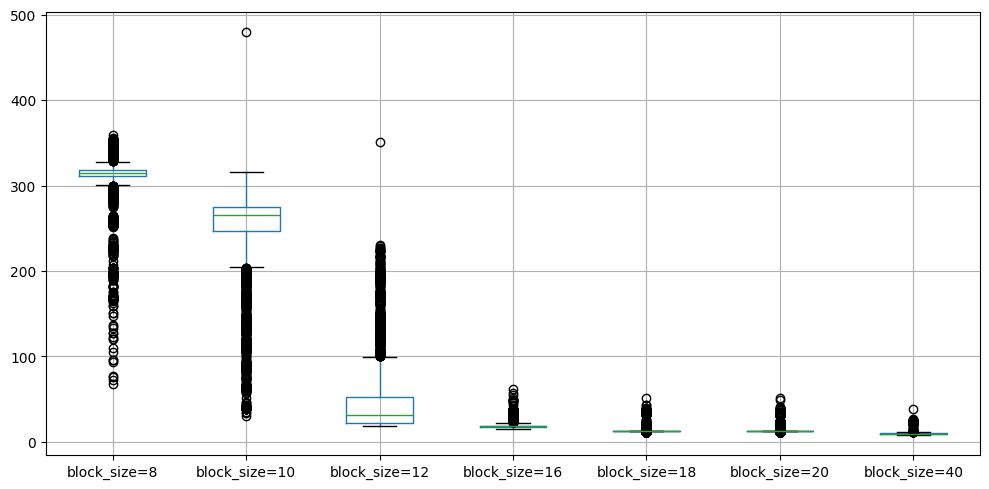

In [21]:
generate_plots_for_grouping("data/contour-relaxation/block-size")

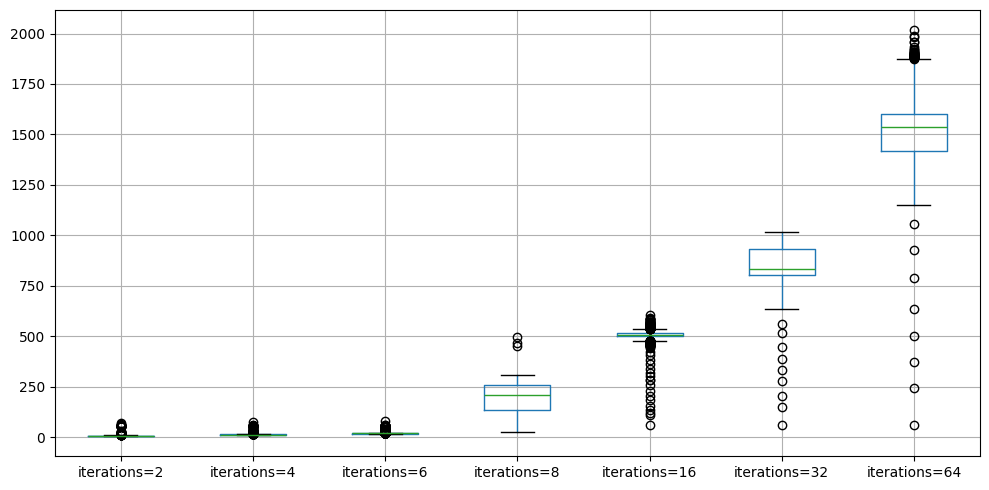

In [22]:
generate_plots_for_grouping("data/contour-relaxation/iterations")